In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import time
import warnings
import random
import math
import pickle
import os
from scipy import linalg
from multiprocessing import Pool, freeze_support
warnings.filterwarnings("ignore")
import function_kaon as tb
%matplotlib inline

def Parameters and Constants

In [4]:
List = [
    ["B451", 500, 0.136981, 0.136409, 64,  [10, 12, 14,]],
    ["B452", 400, 0.137045, 0.136378, 64,  [10, 12, 14, 16]],
    ["N450", 280, 0.137099, 0.136353, 128, [10, 12, 14, 16]],
    ["N304", 420, 0.137079, 0.136665, 128, [15, 18, 21, 24]],
    ["N305", 250, 0.137025, 0.136676, 128, [15, 18, 21, 24]],
]

i = 2
run = 0
conf_name = List[i][0]
Lt = List[i][4]
Nconf = List[i][1]
kappa_l = str(List[i][2])
kappa_s = str(List[i][3])

GEVP analyze

In [5]:
moment = ["000","100"]
gs = "-gs90-gs90"
two_pt_dir = conf_name + "/average_data/2pt_data/"
reweightingfactors_dir = "reweightingfactors/" + conf_name + ".dat"
data_m, data_b, data, gevp_vel, gevp_vel_b, gevp_vec = ([[] for _ in range(len(moment))] for _ in range(6))
xdata = np.linspace(0,int(Lt/2),int(Lt/2+1))
reweightingfactors = np.loadtxt(reweightingfactors_dir)[:4*Nconf:4,3]
for m, mom in enumerate(moment):
    base_path = two_pt_dir + "correlator-"
    suffix = f"-{kappa_l}-{kappa_s}-{mom}{gs}.dat"
    filename = [
        f"{base_path}15-15{suffix}",
        f"{base_path}15-7{suffix}",
        f"{base_path}7-15{suffix}",
        f"{base_path}7-7{suffix}"
    ]

    for f, name in enumerate(filename):
        adata = tb.Cut_conf(np.loadtxt(name), Lt)[:Nconf, :int(Lt/2+1), 0] * reweightingfactors.reshape(Nconf, 1)
        if f == 1 or f == 2:
            sign = -1
        else:
            sign = 1
        #adata = np.swapaxes(tb.Fold_data(np.swapaxes(adata, 0, 1), sign), 0, 1)
        data[m].append(adata)

    data_m[m] = np.array([np.mean(d, axis=0) for d in data[m]]).reshape(2, 2, int(Lt/2+1))
    data_b[m] = np.array([tb.Bootstrap(d, 4, 0) for d in data[m]]).reshape(2, 2, 4 * Nconf, int(Lt/2+1))

    # Flip sign
    data_m[m][1,1] = -1*data_m[m][1,1]
    data_m[m][0,1] = -1*data_m[m][0,1]
    data_b[m][1,1] = -1*data_b[m][1,1]
    data_b[m][0,1] = -1*data_b[m][0,1]

    # Swap axes
    data_m[m] = np.swapaxes(data_m[m], 0, 2)
    data_m[m] = np.swapaxes(data_m[m], 1, 2)
    data_b[m] = np.swapaxes(data_b[m], 0, 3)
    data_b[m] = np.swapaxes(data_b[m], 1, 2)
    data_b[m] = np.swapaxes(data_b[m], 2, 3)

    # GEVP results
    gevp_res = tb.GEVP(data_m[m], data_b[m], [0, 1])
    gevp_vel[m], gevp_vel_b[m], gevp_vec[m] = gevp_res.vel, gevp_res.vel_bs, gevp_res.vec

fitting GEVP result

In [6]:
# fitting model
def con_fun(x, *a):
    return a[0]

def exp_fun(x,*a):
    return a[1]*np.exp(-1*a[0]*x)

In [7]:
# save the fitting result
dir = "kaon_result/"
name = conf_name + "GEVP_fitting_result.pickle"
if run == 1:
    # control minimum and maximum range
    up, down = 15, 20
    # the best fitting range is defined by AIC
    GEVPfitting_effectmass = [[],[]]
    GEVPfitting_exponential = [[],[]]
    for m in range(2):
        freeze_support()
        GEVPfitting_effectmass[m] = tb.Find_best_fitting_AIC_range_linear(con_fun, xdata[up:down-1], tb.Effectmass_ln(gevp_vel[m][up:down,0],int(Lt/2))
                                                                ,tb.Effectmass_ln(gevp_vel_b[m][up:down,:,0],int(Lt/2)),p0=[1e-5], bounds=[[0],[1e5]])
        GEVPfitting_exponential[m] = tb.Find_best_fitting_AIC_range_linear(exp_fun, xdata[up:down], gevp_vel[m][up:down,0], gevp_vel_b[m][up:down,:,0], p0=[1e-5,1e-5], bounds=[[0,0],[1e5,1e5]])
    if not os.path.exists(dir):
        os.makedirs(dir)

    fitting_result = {"effectmass":GEVPfitting_effectmass, "exponential":GEVPfitting_exponential}
    with open(dir + name, 'wb') as f:
        pickle.dump(fitting_result, f)

plot result of GEVP

range: 12 to 48
range: 11 to 54


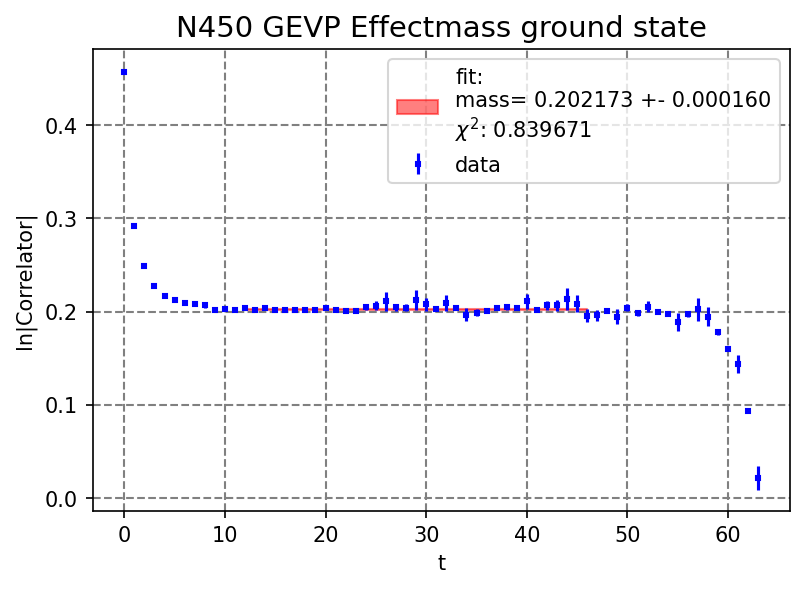

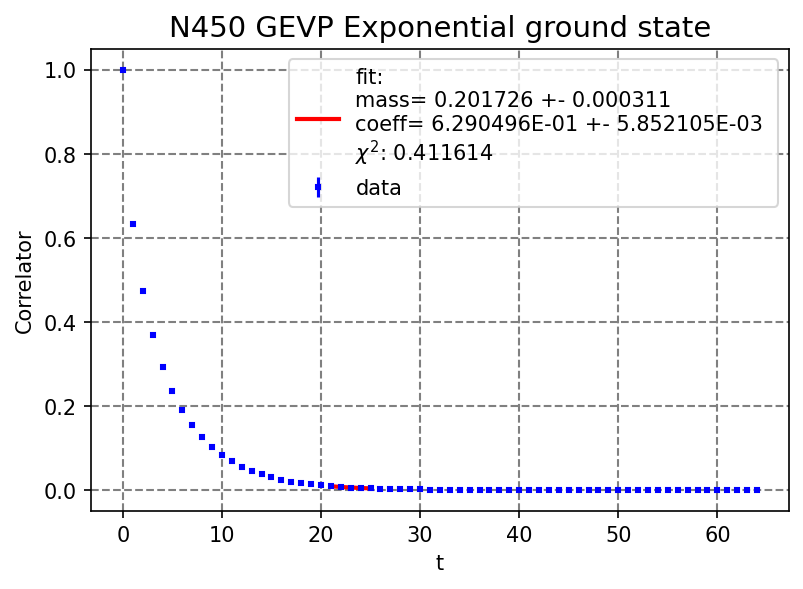

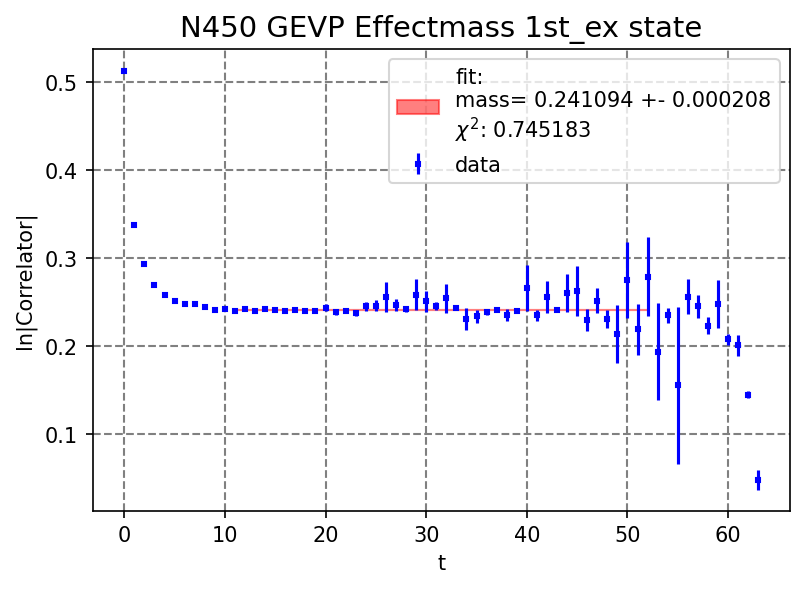

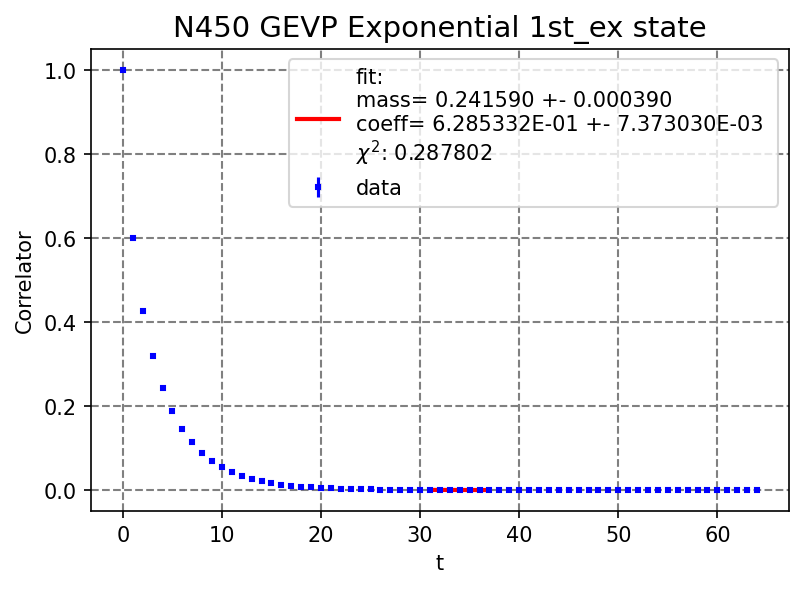

In [8]:
# load the fitting result
dir = "kaon_result/"
dirp = "kaon_2ptplot"
name = conf_name + "GEVP_fitting_result.pickle"
with open(dir + name, 'rb') as f:
    fitting_result = pickle.load(f)

GEVPfitting_effectmass = fitting_result["effectmass"]
GEVPfitting_exponential = fitting_result["exponential"]

for m in range(2):
    if m == 0:
        state = "ground state"
    else:
        state = "1st_ex state"
        
    # plot Effectmass
    a, b = GEVPfitting_effectmass[m].best_range
    up, down = int(a), int(b)
    print(f'range: {up} to {down}')
    res = GEVPfitting_effectmass[m].best_fit.res[0]
    err = tb.Bootstrap_erro(np.array(GEVPfitting_effectmass[m].best_fit.boots_res)[:,0],0)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi = 150)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 1)
    plt.title(conf_name + " GEVP Effectmass " + state,fontsize = 14)
    plt.xlabel("t")
    plt.ylabel("ln|Correlator|")
    ax.errorbar(xdata[:-1], tb.Effectmass_ln(gevp_vel[m][:,0],int(Lt/2)), tb.Bootstrap_erro(tb.Effectmass_ln(gevp_vel_b[m][:,:,0],int(Lt/2)),1)
                    , label = 'data', linestyle = '', color = 'blue', marker = 's', ms = 2)
    ax.fill_between(xdata[up:down-1], res - err,  res + err, color = 'red', alpha = 0.5
                    , label='fit:\nmass= %4f +- %4f\n$\chi^2$: %4f' %(res, err ,GEVPfitting_effectmass[m].best_fit.chi))
    plt.legend(loc = 0)
    plt.savefig(dirp + conf_name + "GEVP_Effectmass_" + state + ".png")

    # plot exponential
    a, b = GEVPfitting_exponential[m].best_range
    up, down = int(a), int(b)
    xline = np.linspace(xdata[up],xdata[down],1000)
    fitting = GEVPfitting_exponential[m].best_fit
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi = 150)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 1)
    plt.title(conf_name + " GEVP Exponential " + state,fontsize = 14)
    plt.xlabel("t")
    plt.ylabel("Correlator")
    ax.errorbar(xdata, gevp_vel[m][:,0], tb.Bootstrap_erro(gevp_vel_b[m][:,:,0],1)
                    , label = 'data', linestyle = '', color = 'blue', marker = 's', ms = 2)
    ax.plot(xline, exp_fun(xline, fitting.res[0], fitting.res[1])
        , linestyle = '-', color = 'red', linewidth = 2
        , label='fit:\nmass= %4f +- %4f \ncoeff= %4E +- %4E \n$\chi^2$: %4f' %(fitting.res[0],tb.Bootstrap_erro(np.array(fitting.boots_res)[:,0])
                                                                               ,fitting.res[1],tb.Bootstrap_erro(np.array(fitting.boots_res)[:,1])
                                                                               ,fitting.chi))
    plt.legend(loc = 0)
    plt.savefig(dirp + conf_name + "GEVP_Exponential_" + state + ".png")

GEVP Optimized Matrix

In [9]:
name = conf_name + "GEVP_OP_fitting_result.pickle"

op_vel, op_vel_b, eigenvectors= ([[] for _ in range(len(moment))] for _ in range(3))
for m in range(2):
    if m == 0:
        state = "ground state"
    else:
        state = "1st_ex state"
    
    a, b = GEVPfitting_exponential[m].best_range
    eigenvectors[m] = gevp_vec[m][int((a + b)/2)][:,0]
    print(f'{state} eigen vector: {eigenvectors[m]}')
    op_res = tb.GEVP(data_m[m], data_b[m], [0, 1], vec0=eigenvectors[m])
    op_vel[m], op_vel_b[m] = op_res.optimize, op_res.optimize_bs

if run == 1:
    # the best fitting range is defined by AIC
    OPfitting_exponential = [[],[]]
    for m in range(2):
        OPfitting_exponential[m] = tb.Find_best_fitting_AIC_range(exp_fun, xdata, op_vel[m][:,0], op_vel_b[m][:,:,0], p0=[1e-5,1e-5], bounds=[[0,0],[1e5,1e5]])
    if not os.path.exists(dir):
        os.makedirs(dir)
    fitting_result = {
        "eigenvector": eigenvectors,
        "exponential": OPfitting_exponential
    }
    with open(dir + name, 'wb') as f:
        pickle.dump(fitting_result, f)

ground state eigen vector: [ 0.78293571+0.j -0.62210262+0.j]
1st_ex state eigen vector: [ 0.76706484+0.j -0.64156959+0.j]


plot result of GEVP Optimized

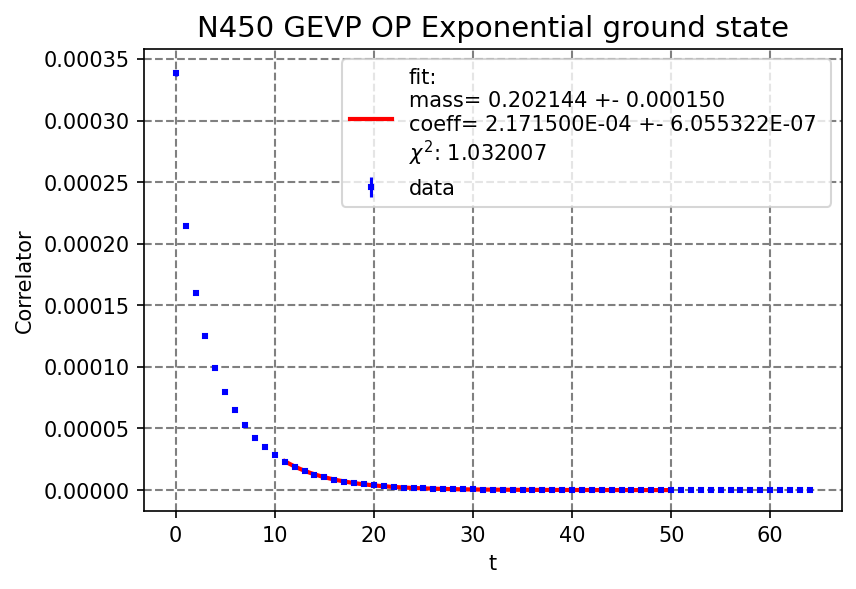

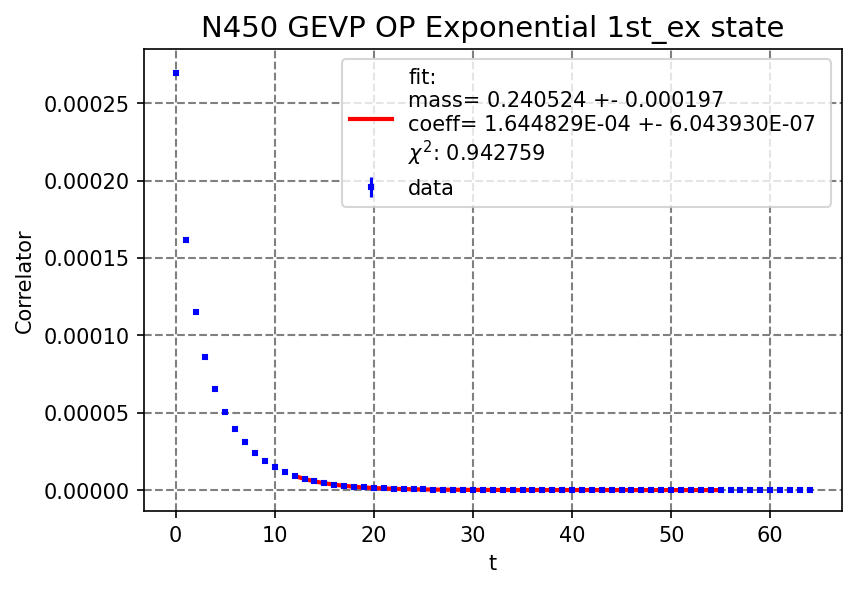

In [10]:
# load the fitting result
dir = "kaon_result/"
name = conf_name + "GEVP_OP_fitting_result.pickle"

with open(dir + name, 'rb') as f:
    fitting_result = pickle.load(f)

eigenvectors = fitting_result["eigenvector"]
OPfitting_exponential = fitting_result["exponential"]

for m in range(2):
    if m == 0:
        state = "ground state"
    else:
        state = "1st_ex state"

    # plot exponential
    a, b = OPfitting_exponential[m].best_range
    up, down = int(a), int(b)
    xline = np.linspace(xdata[up],xdata[down],1000)
    fitting = OPfitting_exponential[m].best_fit
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi = 150)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 1)
    plt.title(conf_name + " GEVP OP Exponential " + state,fontsize = 14)
    plt.xlabel("t")
    plt.ylabel("Correlator")
    ax.errorbar(xdata, op_vel[m][:,0], tb.Bootstrap_erro(op_vel_b[m][:,:,0],1)
                    , label = 'data', linestyle = '', color = 'blue', marker = 's', ms = 2)
    ax.plot(xline, exp_fun(xline, fitting.res[0], fitting.res[1])
        , linestyle = '-', color = 'red', linewidth = 2
        , label='fit:\nmass= %4f +- %4f \ncoeff= %4E +- %4E \n$\chi^2$: %4f' %(fitting.res[0],tb.Bootstrap_erro(np.array(fitting.boots_res)[:,0])
                                                                               ,fitting.res[1],tb.Bootstrap_erro(np.array(fitting.boots_res)[:,1])
                                                                               ,fitting.chi))
    plt.legend(loc = 0)
    plt.savefig(dirp + conf_name + "GEVP_OP_Exponential_" + state + ".png")

3pt correlator 

In [11]:
#define the directory of input data
Ntau = 30
three_pt_dir = conf_name + "/"
kappa_hs = ["0.104000","0.115000","0.124500"]
tau_es = List[i][5]
R_im_odd, R_re_odd, R_im_eve, R_re_eve = [np.zeros((len(kappa_hs), Ntau)).tolist() for _ in range(4)]
MR_im_odd, MR_re_odd, MR_im_eve, MR_re_eve = [np.zeros((len(kappa_hs), Ntau)).tolist() for _ in range(4)]
BR_im_odd, BR_re_odd, BR_im_eve, BR_re_eve = [np.zeros((len(kappa_hs), Ntau)).tolist() for _ in range(4)]
Odd_im, Even_im, Odd_re, Even_re = [np.zeros((len(kappa_hs), Ntau, len(tau_es))) for _ in range(4)]
Odd_im_b, Even_im_b, Odd_re_b, Even_re_b = [np.zeros((len(kappa_hs), Ntau, len(tau_es), 4*Nconf)) for _ in range(4)]

for i, kappa_h in enumerate(kappa_hs):
    three_pt_data = tb.hadronic_tensor(three_pt_dir, kappa_l, kappa_s, kappa_h, Nconf, Lt, tau_es, fitting_result)
    for tau in range(Ntau):
        for t_e in range(len(tau_es)):
            #flip the sign (according to the results of Excited state analysis)
            Odd_im[i][tau][t_e] = -1*three_pt_data.im_odd[t_e][0][-tau]
            Even_im[i][tau][t_e] = 1*three_pt_data.im_even[t_e][0][-tau]
            Odd_im_b[i][tau][t_e] = -1*three_pt_data.im_odd_b[t_e][0][:,-tau]
            Even_im_b[i][tau][t_e] = 1*three_pt_data.im_even_b[t_e][0][:,-tau]
            Odd_re[i][tau][t_e] = -1*three_pt_data.re_odd[t_e][0][-tau]
            Even_re[i][tau][t_e] = -1*three_pt_data.re_even[t_e][0][-tau]
            Odd_re_b[i][tau][t_e] = -1*three_pt_data.re_odd_b[t_e][0][:,-tau]
            Even_re_b[i][tau][t_e] = -1*three_pt_data.re_even_b[t_e][0][:,-tau]
        R_re_odd[i][tau] = tb.Fit_cov(con_fun, np.array(tau_es), Odd_re[i][tau][:], Odd_re_b[i][tau][:][:])
        R_re_eve[i][tau] = tb.Fit_cov(con_fun, np.array(tau_es), Even_re[i][tau][:], Even_re_b[i][tau][:][:])
        R_im_odd[i][tau] = tb.Fit_cov(con_fun, np.array(tau_es), Odd_im[i][tau][:], Odd_im_b[i][tau][:][:])
        R_im_eve[i][tau] = tb.Fit_cov(con_fun, np.array(tau_es), Even_im[i][tau][:], Even_im_b[i][tau][:][:])
        
        MR_re_odd[i][tau] = R_re_odd[i][tau].res[0]
        MR_re_eve[i][tau] = R_re_eve[i][tau].res[0]
        MR_im_odd[i][tau] = R_im_odd[i][tau].res[0]
        MR_im_eve[i][tau] = R_im_eve[i][tau].res[0]
        
        BR_re_odd[i][tau] = np.array(R_re_odd[i][tau].boots_res)[:,0]
        BR_re_eve[i][tau] = np.array(R_re_eve[i][tau].boots_res)[:,0]
        BR_im_odd[i][tau] = np.array(R_im_odd[i][tau].boots_res)[:,0]
        BR_im_eve[i][tau] = np.array(R_im_eve[i][tau].boots_res)[:,0]


[1.e-05]


ValueError: not enough values to unpack (expected 2, got 1)

Excited State Contamination

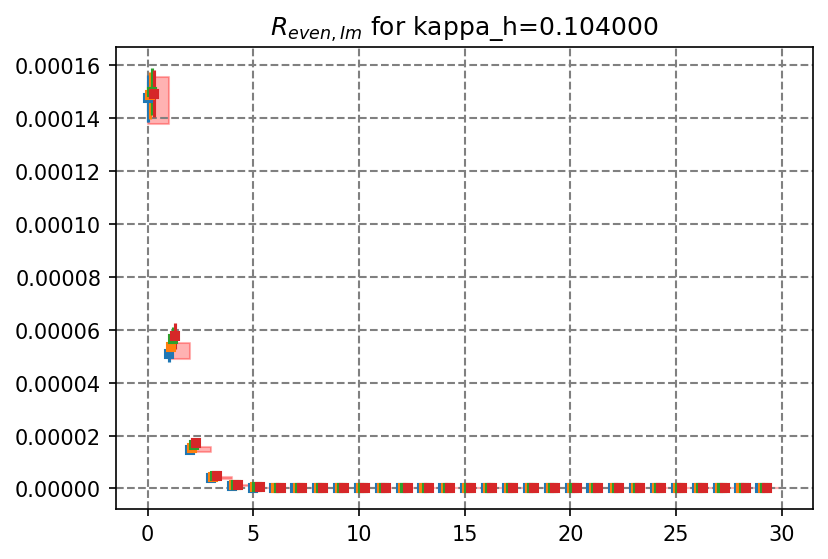

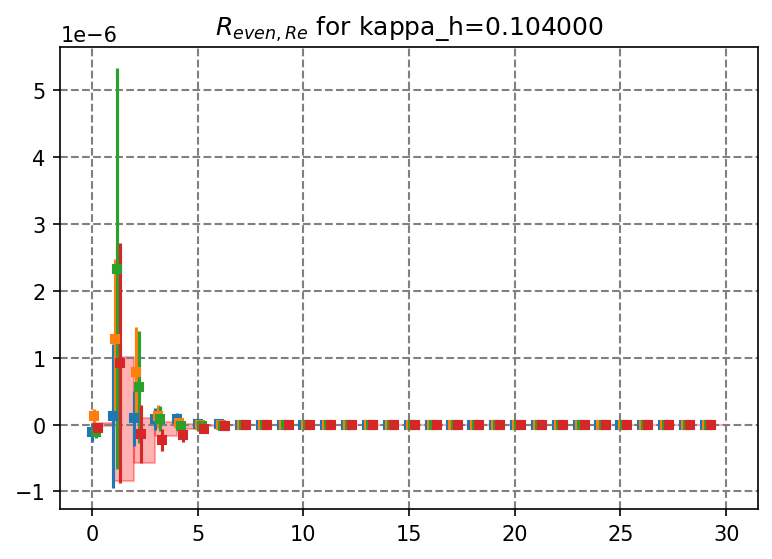

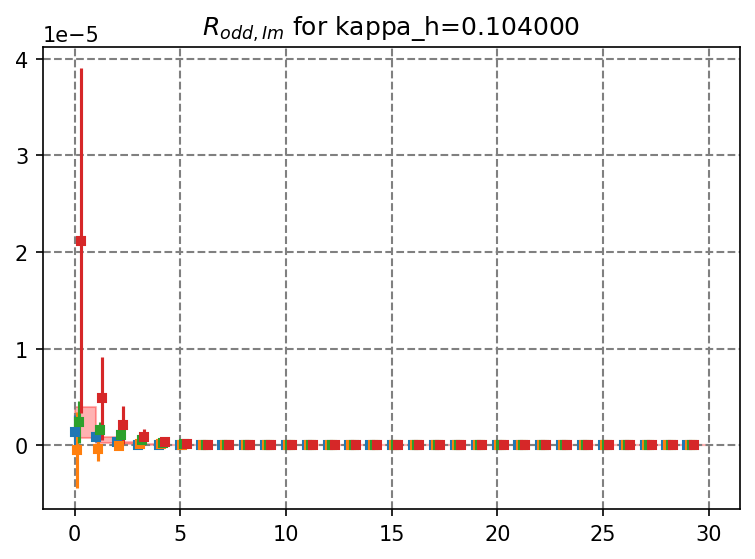

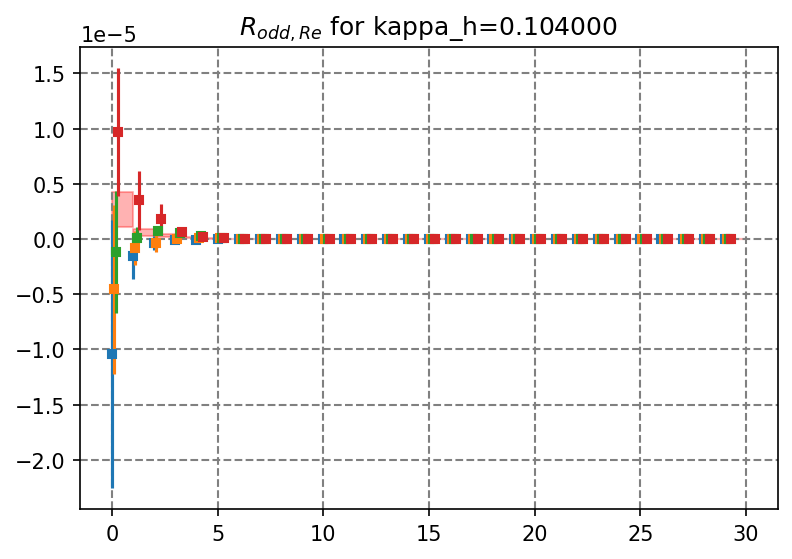

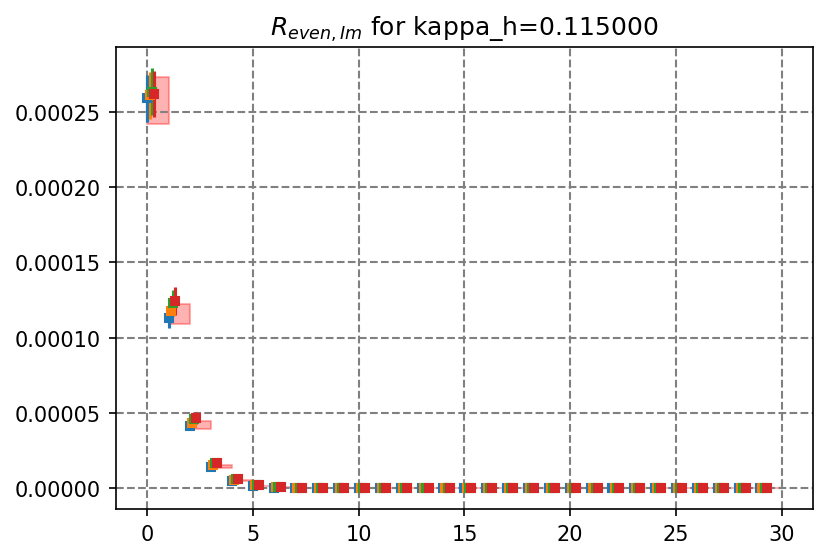

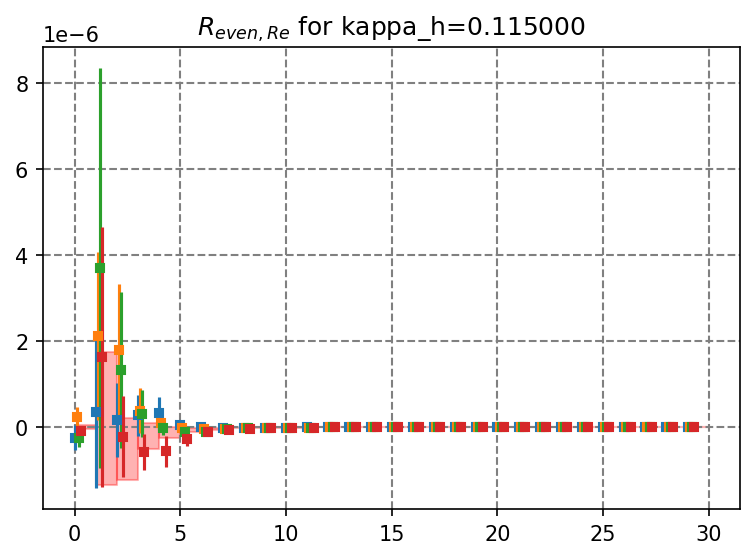

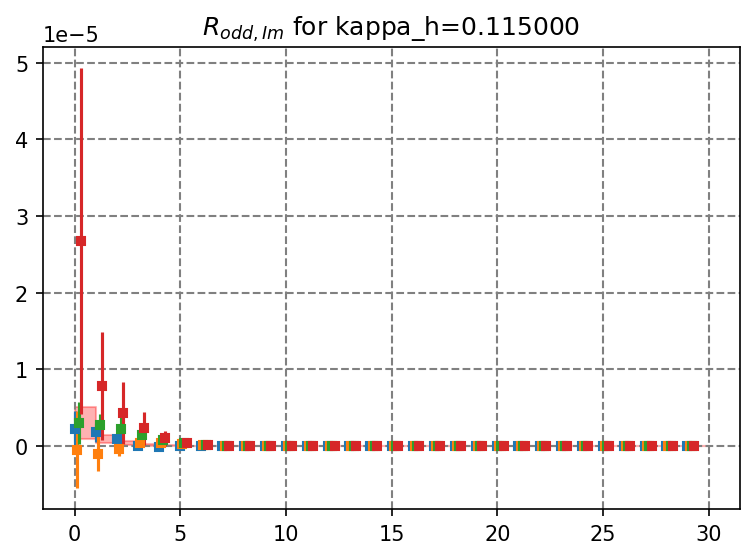

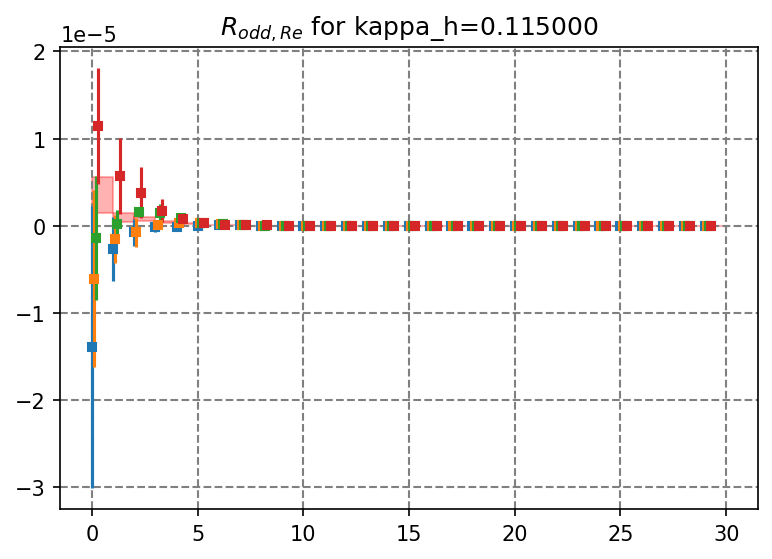

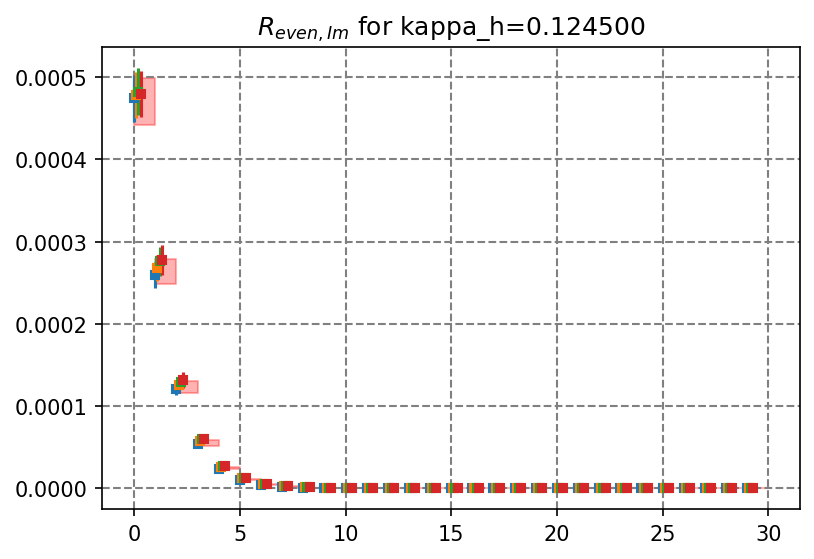

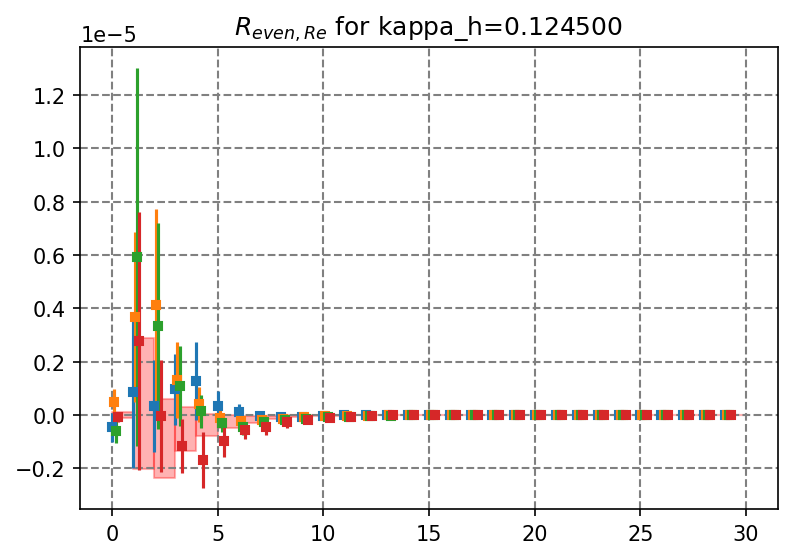

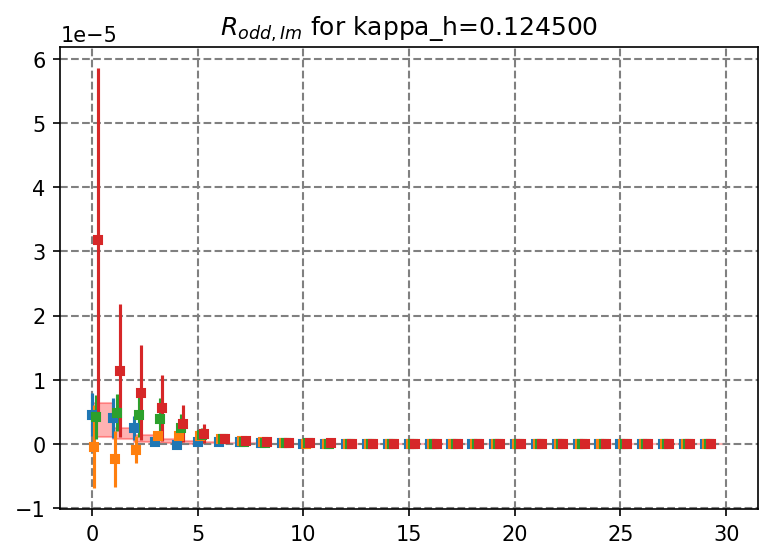

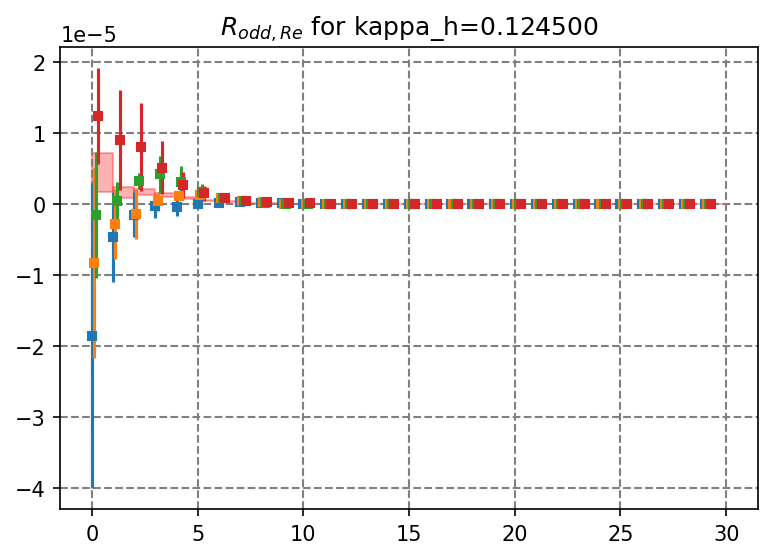

In [ ]:
for h, kappa_h in enumerate(kappa_hs):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.title(f"$R_{{even,Im}}$ for kappa_h={kappa_h}")
    for i in range(len(tau_es)):        
        ax.errorbar(np.array(range(Ntau)) + 0.1*i, Even_im[h, :, i], tb.Bootstrap_erro(Even_im_b[h, :, i, :], 1), linestyle='',
                  marker='s', ms=4)
    for j in range(Ntau):
        y_fit = MR_im_eve[h][j]
        y_err = tb.Bootstrap_erro(BR_im_eve[h][j], 0)
        ax.fill_between(np.linspace(j, j+1, 10), y_fit - y_err, y_fit + y_err, color='red', alpha=0.3)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.title(f"$R_{{even,Re}}$ for kappa_h={kappa_h}")
    for i in range(len(tau_es)):        
        ax.errorbar(np.array(range(Ntau)) + 0.1*i, Even_re[h, :, i], tb.Bootstrap_erro(Even_re_b[h, :, i, :], 1), linestyle='',
                  marker='s', ms=4)
    for j in range(Ntau):
        y_fit = MR_re_eve[h][j]
        y_err = tb.Bootstrap_erro(BR_re_eve[h][j], 0)
        ax.fill_between(np.linspace(j, j+1, 10), y_fit - y_err, y_fit + y_err, color='red', alpha=0.3)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.title(f"$R_{{odd,Im}}$ for kappa_h={kappa_h}")
    for i in range(len(tau_es)):        
        ax.errorbar(np.array(range(Ntau)) + 0.1*i, Odd_im[h, :, i], tb.Bootstrap_erro(Odd_im_b[h, :, i, :], 1), linestyle='',
                  marker='s', ms=4)
    for j in range(Ntau):
        y_fit = MR_im_odd[h][j]
        y_err = tb.Bootstrap_erro(BR_im_odd[h][j], 0)
        ax.fill_between(np.linspace(j, j+1, 10), y_fit - y_err, y_fit + y_err, color='red', alpha=0.3)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.title(f"$R_{{odd,Re}}$ for kappa_h={kappa_h}")
    for i in range(len(tau_es)):        
        ax.errorbar(np.array(range(Ntau)) + 0.1*i, Odd_re[h, :, i], tb.Bootstrap_erro(Odd_re_b[h, :, i, :], 1), linestyle='',
                  marker='s', ms=4)
    for j in range(Ntau):
        y_fit = MR_re_odd[h][j]
        y_err = tb.Bootstrap_erro(BR_re_odd[h][j], 0)
        ax.fill_between(np.linspace(j, j+1, 10), y_fit - y_err, y_fit + y_err, color='red', alpha=0.3)

tree level fitting

In [ ]:
Ek = OPfitting_exponential[1].best_fit.res[0]
def R_even_im_fun(t, *a):
    A = a[0]
    Ephi = a[1] # mphi**2 - q**2
    chi2 = a[2]
    chi4 = a[3]
    C0 = (A/2/Ephi)*np.exp(-Ephi*t)
    C1 = 0.5**2 /(8*Ephi**4) * (3*Ephi*abs(t) + (Ephi*t)**2 +3) - Ek**2 /(8*Ephi**2) * (Ephi*abs(t) - (Ephi*t)**2 + 1)
    C2 = 0.5**4 /384 /Ephi**8 *((Ephi*t)**4 + 5*Ephi*abs(t)*(2*(Ephi)**2 + 21) + 45*(Ephi*t)**2 + 105)
    C3 = -6 *Ek**2 *0.5**2 /384 /Ephi**6 *(-2*(Ephi*abs(t))**3 + 15*Ephi*abs(t) - (Ephi*t)**4 + 3*(Ephi*t)**2 + 15)
    C4 = Ek**4 /384 /Ephi**4 *(-6*(Ephi*abs(t))**3 + 9*Ephi*abs(t) + (Ephi*t)**4 - 3*(Ephi*t)**2 + 9)
    return C0*(1 + C1*chi2 + (C2 + C3 + C4)*chi4)

def R_even_im_fun_B(t, *a):
    A = a[0]
    Ephi = a[1] # mphi**2 - q**2
    chi2 = a[2]
    
    C0 = (A/2/Ephi)*np.exp(-Ephi*t)
    C1 = 0.5**2 /(8*Ephi**4) * (3*Ephi*abs(t) + (Ephi*t)**2 +3) - Ek**2 /(8*Ephi**2) * (Ephi*abs(t) - (Ephi*t)**2 + 1)
    
    return C0*(1 + C1*chi2 )

def R_even_re_fun(t, *a):
    A = a[0]
    Ephi = a[1] # mphi**2 - q**2
    chi2 = a[2]
    chi4 = a[3]
    C0 = (A/2/Ephi)*np.exp(-Ephi*t)
    C2 = 2*t *Ek *0.5 /8 /Ephi**2 *(abs(t)*Ephi + 1)
    C3 = 4*t *Ek *0.5**2 /384 /Ephi**6 *(6*(Ephi*t)**2 + 15 + np.sign(t)*(Ephi*t)**3 + 15*np.sign(t)*Ephi*t)
    C4 = 4*t *Ek**3 *0.5 /384 /Ephi**4 *((Ephi*abs(t))**3 - 9*Ephi*abs(t) - 2*(Ephi*t)**2 - 9)
    return C0*(C2*chi2 + (C3 + C4)*chi4)

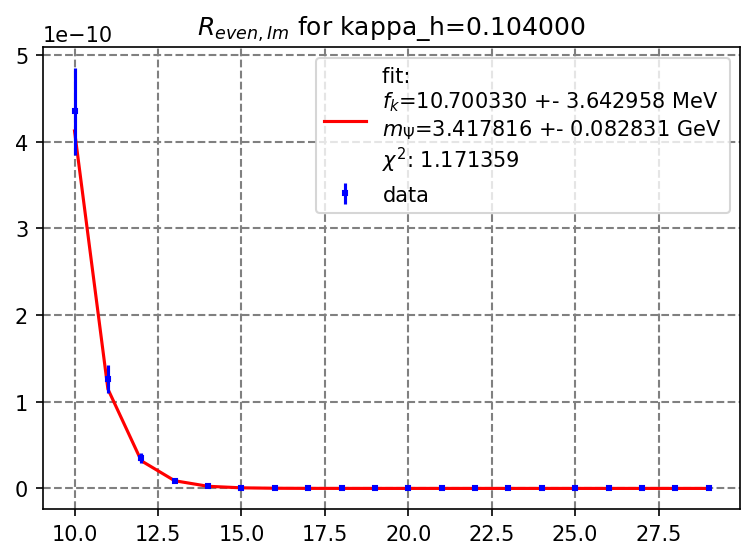

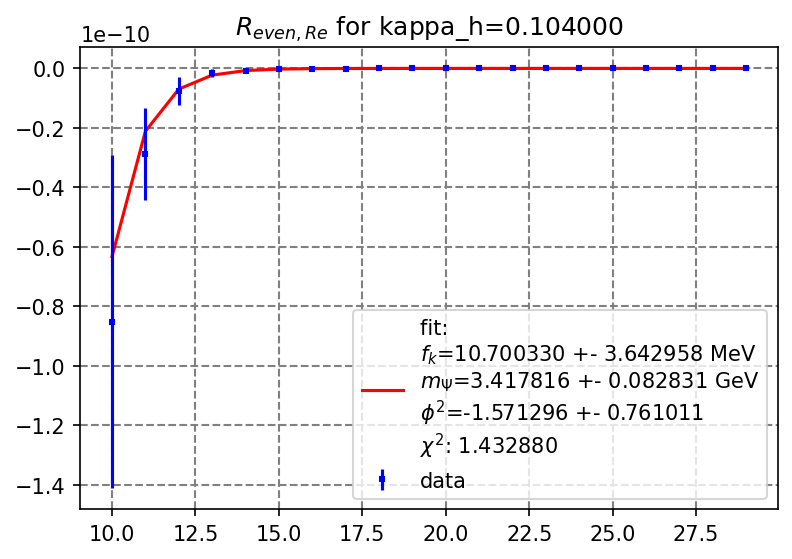

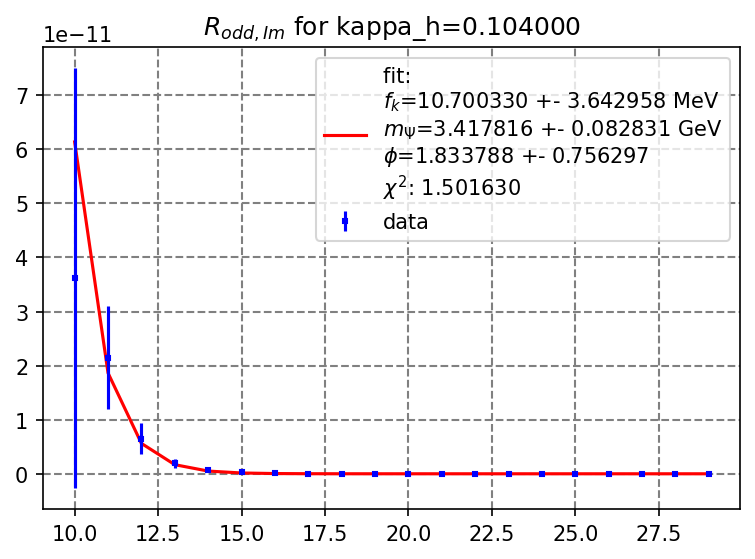

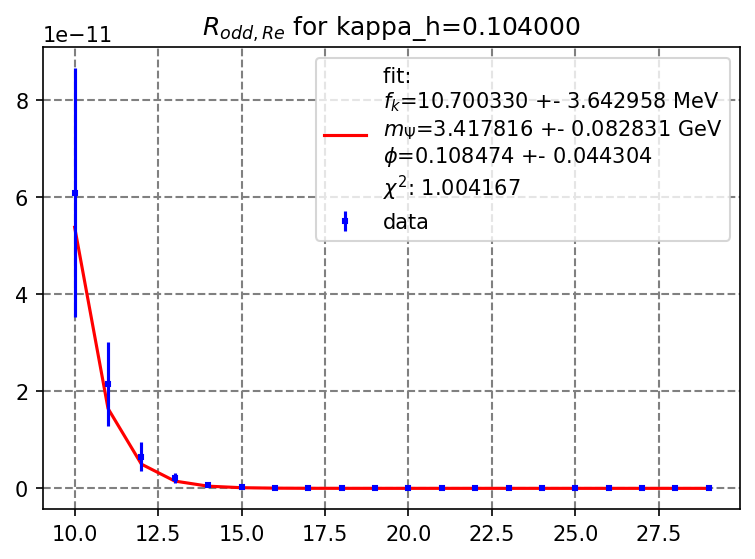

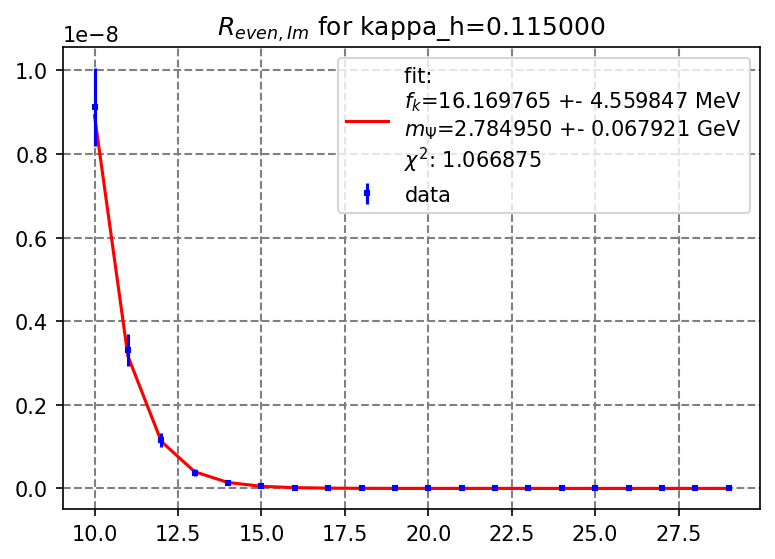

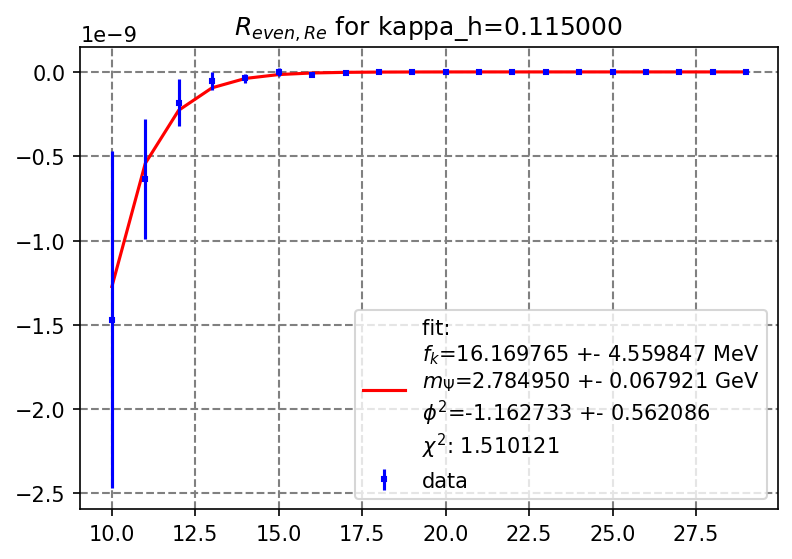

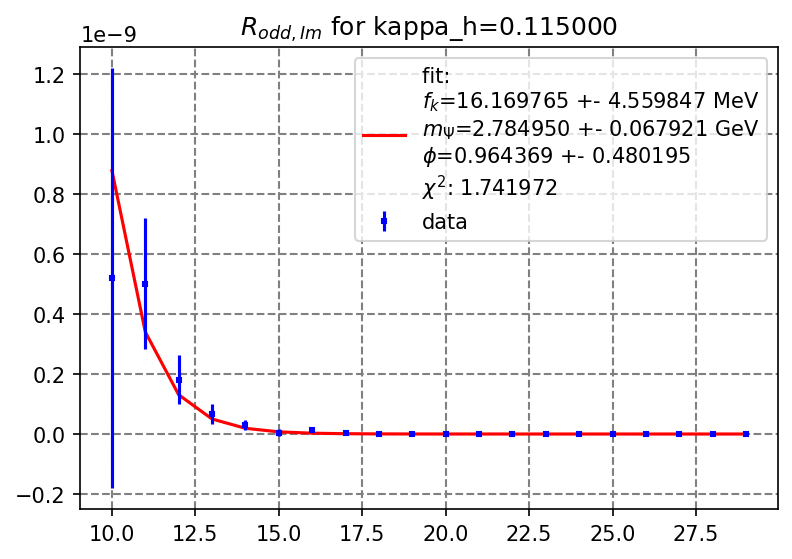

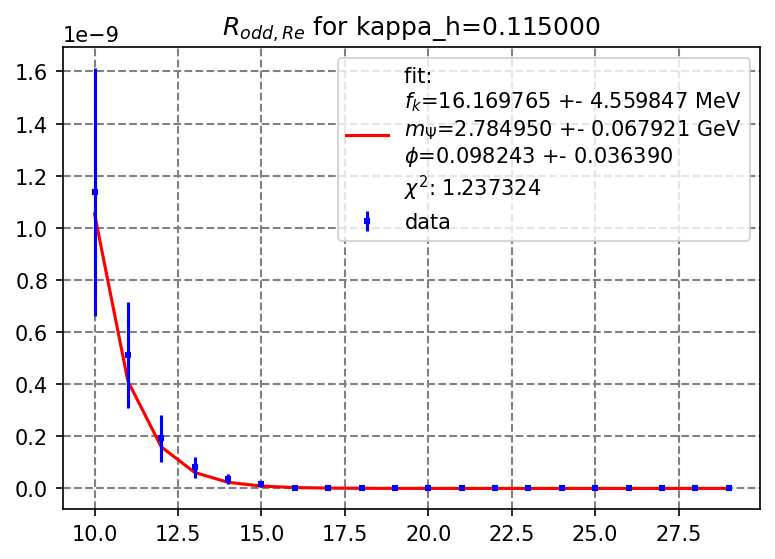

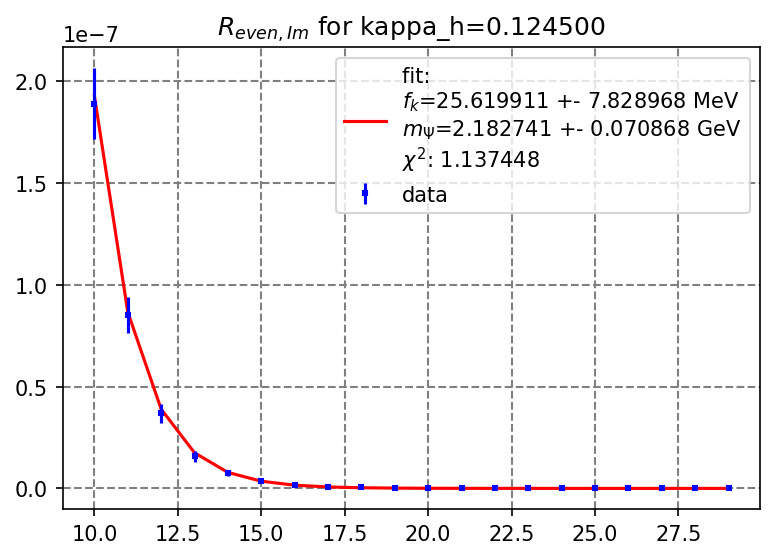

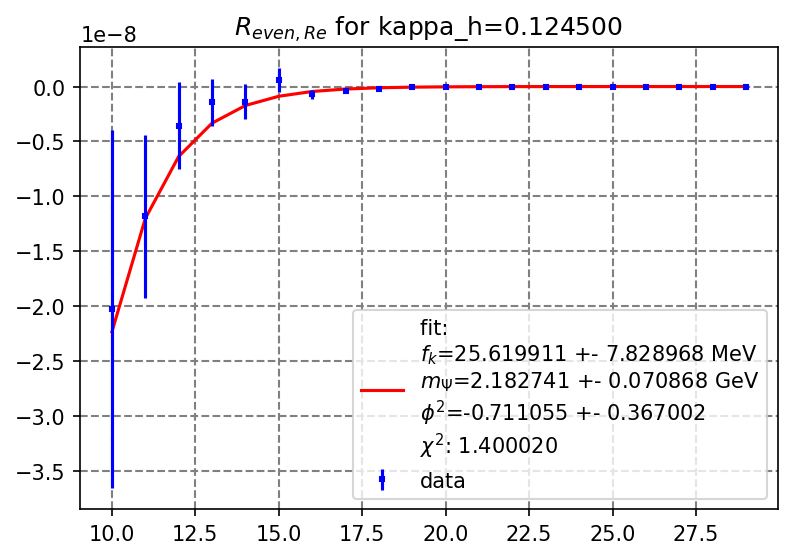

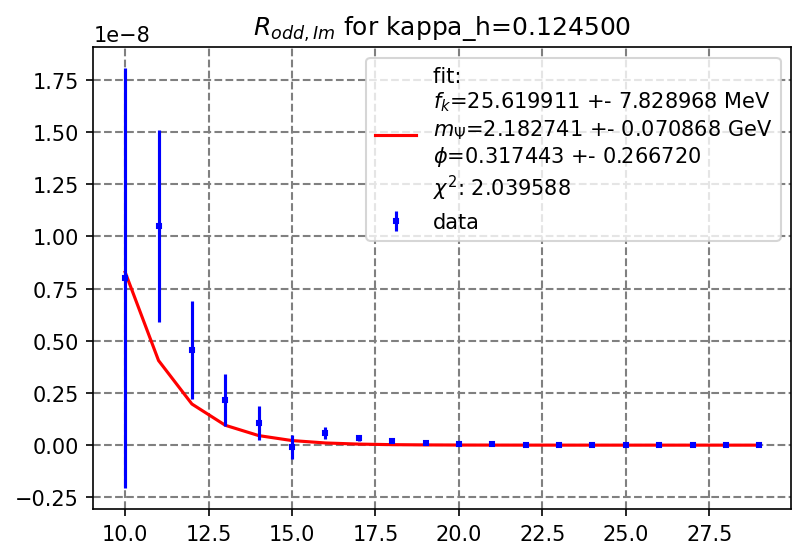

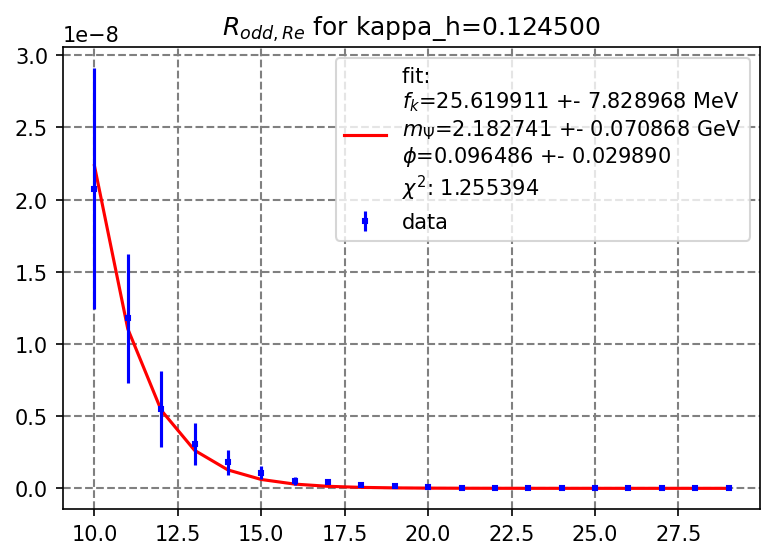

In [ ]:
cutdata = 10
q3 = 1 * 2 *np.pi /32
qsquare = 1.25 * 2 *np.pi /32 * 2 *np.pi /32
pq = 0.5 * 2 *np.pi /32 * 2 *np.pi /32

def R_even_im_fun_tree(t, *a):
    A = a[0] * 2 * Ek * q3
    #Ephi = (a[1]**2 - qsquare)**0.5# Epsi**2 = mphi**2 - q**2
    Ephi = a[1]
    C0 = (A/2/Ephi)*np.exp(-Ephi*t)
    return C0

for h, kappa_h in enumerate(kappa_hs):
    fit_even_im = tb.Fit_cov(R_even_im_fun_tree, np.array(range(Ntau))[cutdata:], np.array(MR_im_eve[h][cutdata:]), np.array(BR_im_eve)[h][cutdata:], maxfev=100000, p0 = [1.0,1.0], bounds= [[-100,-100],[100,100]])
    Ephi = fit_even_im.res[1]
    Fk = fit_even_im.res[0]

    def R_even_re_fun_tree(t, *a):
        A = Fk * 2 * Ek * q3
        chi2 = a[0]
        C0 = (A/2/Ephi)*np.exp(-Ephi*t)
        C2 = 2*t*Ek*pq /8 /Ephi**2 *(abs(t)*Ephi + 1)
        return C0*(C2*chi2)

    def R_odd_im_fun_tree(t, *a):
        A = Fk * 2 * Ek * q3
        chi = a[0]
        C = (A/4/Ephi)*np.exp(-Ephi*t)
        C1 = pq / Ephi**2 * (1 + Ephi *t)
        return C*(C1*chi)

    def R_odd_re_fun_tree(t, *a):
        A = Fk * 2 * Ek * q3
        chi = a[0]
        C = (A/4/Ephi)*np.exp(-Ephi*t)
        C1 = Ek * t
        return C*(C1*chi)

    fit_even_re = tb.Fit_cov(R_even_re_fun_tree, np.array(range(Ntau))[cutdata:], np.array(MR_re_eve[h][cutdata:]), np.array(BR_re_eve)[h][cutdata:], maxfev=100000, p0 = [1.0], bounds= [[-100],[100]])
    fit_odd_im = tb.Fit_cov(R_odd_im_fun_tree, np.array(range(Ntau))[cutdata:], np.array(MR_im_odd[h][cutdata:]), np.array(BR_im_odd)[h][cutdata:], maxfev=100000, p0 = [1.0], bounds= [[-100],[100]])
    fit_odd_re = tb.Fit_cov(R_odd_re_fun_tree, np.array(range(Ntau))[cutdata:], np.array(MR_re_odd[h][cutdata:]), np.array(BR_re_odd)[h][cutdata:], maxfev=100000, p0 = [1.0], bounds= [[-100],[100]])

    af = 0.075
    beta = 5.068

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi = 150)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 1)
    plt.title("$R_{even,Im}$" + " for kappa_h={}".format(kappa_h))
    ax.plot(np.array(range(Ntau))[cutdata:], R_even_im_fun_tree(np.array(range(Ntau))[cutdata:], *fit_even_im.res), 'r-',
            label='fit: \n$f_k$=%4f +- %4f MeV\n$m_\Psi$=%4f +- %4f GeV\n$\chi^2$: %4f' %(fit_even_im.res[0]/af/beta*1000,tb.Bootstrap_erro(np.array(fit_even_im.boots_res)[:,0]/af/beta*1000)
                                                                                    ,(fit_even_im.res[1]**2 + qsquare)**0.5/af/beta,tb.Bootstrap_erro((np.array(fit_even_im.boots_res)[:,1]**2 + qsquare)**0.5/af/beta)
                                                                                    ,fit_even_im.chi))
    ax.errorbar(np.array(range(Ntau))[cutdata:], MR_im_eve[h][cutdata:], tb.Bootstrap_erro(BR_im_eve,2)[h][cutdata:], linestyle = '', color = 'blue'
                , marker = 's', ms = 2, label = 'data')
    plt.legend(loc = 0)
    plt.savefig("tree_level_fitting/" + conf_name + "$R_{even,Im}$" + " for kappa_h={}.png".format(kappa_h))

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi = 150)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 1)
    plt.title("$R_{even,Re}$" + " for kappa_h={}".format(kappa_h))
    ax.plot(np.array(range(Ntau))[cutdata:], R_even_re_fun_tree(np.array(range(Ntau))[cutdata:], *fit_even_re.res), 'r-',
            label='fit: \n$f_k$=%4f +- %4f MeV\n$m_\Psi$=%4f +- %4f GeV\n$\phi^2$=%4f +- %4f \n$\chi^2$: %4f' 
                                                                                    %(fit_even_im.res[0]/af/beta*1000,tb.Bootstrap_erro(np.array(fit_even_im.boots_res)[:,0]/af/beta*1000)
                                                                                    ,(fit_even_im.res[1]**2 + qsquare)**0.5/af/beta,tb.Bootstrap_erro((np.array(fit_even_im.boots_res)[:,1]**2 + qsquare)**0.5/af/beta)
                                                                                    ,fit_even_re.res[0],tb.Bootstrap_erro(np.array(fit_even_re.boots_res)[:,0])
                                                                                    ,fit_even_re.chi))
    ax.errorbar(np.array(range(Ntau))[cutdata:], MR_re_eve[h][cutdata:], tb.Bootstrap_erro(BR_re_eve,2)[h, cutdata:], linestyle = '', color = 'blue'
                , marker = 's', ms = 2, label = 'data')
    plt.legend(loc = 0)
    plt.savefig("tree_level_fitting/" + conf_name + "$R_{even,Re}$" + " for kappa_h={}.png".format(kappa_h))

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi = 150)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 1)
    plt.title("$R_{odd,Im}$" + " for kappa_h={}".format(kappa_h))
    ax.plot(np.array(range(Ntau))[cutdata:], R_odd_im_fun_tree(np.array(range(Ntau))[cutdata:], *fit_odd_im.res), 'r-',
            label='fit: \n$f_k$=%4f +- %4f MeV\n$m_\Psi$=%4f +- %4f GeV\n$\phi$=%4f +- %4f \n$\chi^2$: %4f' 
                                                                                    %(fit_even_im.res[0]/af/beta*1000,tb.Bootstrap_erro(np.array(fit_even_im.boots_res)[:,0]/af/beta*1000)
                                                                                    ,(fit_even_im.res[1]**2 + qsquare)**0.5/af/beta,tb.Bootstrap_erro((np.array(fit_even_im.boots_res)[:,1]**2 + qsquare)**0.5/af/beta)
                                                                                    ,fit_odd_im.res[0],tb.Bootstrap_erro(np.array(fit_odd_im.boots_res)[:,0])
                                                                                    ,fit_odd_im.chi))
    ax.errorbar(np.array(range(Ntau))[cutdata:], MR_im_odd[h][cutdata:], tb.Bootstrap_erro(BR_im_odd,2)[h, cutdata:], linestyle = '', color = 'blue'
                , marker = 's', ms = 2, label = 'data')
    plt.legend(loc = 0)
    plt.savefig("tree_level_fitting/" + conf_name + "$R_{odd,Im}$" + " for kappa_h={}.png".format(kappa_h))

    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi = 150)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 1)
    plt.title("$R_{odd,Re}$" + " for kappa_h={}".format(kappa_h))
    ax.plot(np.array(range(Ntau))[cutdata:], R_odd_re_fun_tree(np.array(range(Ntau))[cutdata:], *fit_odd_re.res), 'r-',
            label='fit: \n$f_k$=%4f +- %4f MeV\n$m_\Psi$=%4f +- %4f GeV\n$\phi$=%4f +- %4f \n$\chi^2$: %4f' 
                                                                                    %(fit_even_im.res[0]/af/beta*1000,tb.Bootstrap_erro(np.array(fit_even_im.boots_res)[:,0]/af/beta*1000)
                                                                                    ,(fit_even_im.res[1]**2 + qsquare)**0.5/af/beta,tb.Bootstrap_erro((np.array(fit_even_im.boots_res)[:,1]**2 + qsquare)**0.5/af/beta)
                                                                                    ,fit_odd_re.res[0],tb.Bootstrap_erro(np.array(fit_odd_re.boots_res)[:,0])
                                                                                    ,fit_odd_re.chi))
    ax.errorbar(np.array(range(Ntau))[cutdata:], MR_re_odd[h][cutdata:], tb.Bootstrap_erro(BR_re_odd,2)[h, cutdata:], linestyle = '', color = 'blue'
                , marker = 's', ms = 2, label = 'data')
    plt.legend(loc = 0)
    plt.savefig("tree_level_fitting/" + conf_name + "$R_{odd,Re}$" + " for kappa_h={}.png".format(kappa_h))

    # Save the fit results to a file
    with open(dir + conf_name + "tree_fit_results_kappa_h_{}.txt".format(kappa_h), "w") as f:
        f.write("Fit results for kappa_h = {}\n".format(kappa_h))
        f.write("f_k = {} +/- {}\n".format(fit_even_im.res[0], tb.Bootstrap_erro(np.array(fit_even_im.boots_res)[:,0])))
        f.write("m_Psi = {} +/- {}\n".format((fit_even_im.res[1]**2 + qsquare)**0.5, tb.Bootstrap_erro((np.array(fit_even_im.boots_res)[:,1]**2 + qsquare)**0.5)))
        f.write("chi^2 = {}\n".format(fit_even_im.chi))
        f.write("phi^2 = {} +/- {}\n".format(fit_even_re.res[0], tb.Bootstrap_erro(np.array(fit_even_re.boots_res)[:,0])))
        f.write("chi^2 = {}\n".format(fit_even_re.chi))
        f.write("phi = {} +/- {}\n".format(fit_odd_im.res[0], tb.Bootstrap_erro(np.array(fit_odd_im.boots_res)[:,0])))
        f.write("chi^2 = {}\n".format(fit_odd_im.chi))
        f.write("phi~ = {} +/- {}\n".format(fit_odd_re.res[0], tb.Bootstrap_erro(np.array(fit_odd_re.boots_res)[:,0])))
        f.write("chi^2 = {}\n".format(fit_odd_re.chi))                                                                  